In [1]:
# Production Control — EO Compliance & Assembly Line Monitoring
# Data source:
#   eo_changes.csv, bom_expected.csv, production_actual.csv
#   generated via Making_data.ipynb
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ------------------------------------------------------------
# Visualization setup:
# Configure font fallback (Windows / macOS / Linux compatible)
# and basic plotting style
# ------------------------------------------------------------
_fonts = [f.name for f in fm.fontManager.ttflist]
for font in ["Malgun Gothic", "AppleGothic", "NanumGothic", "DejaVu Sans"]:
    if font in _fonts or any(font.lower() in f.lower() for f in _fonts):
        plt.rcParams["font.family"] = font
        break
else:
    plt.rcParams["font.family"] = "sans-serif"

plt.rcParams["axes.unicode_minus"] = False

try:
    import seaborn as sns
    sns.set_style("whitegrid")
    PALETTE = sns.color_palette("husl", 10)
except Exception:
    PALETTE = None

# ------------------------------------------------------------
# Data paths (relative to the current notebook directory)
# ------------------------------------------------------------
BASE = os.path.join(os.getcwd(), "data")
EO_PATH = os.path.join(BASE, "eo_changes.csv")
BOM_PATH = os.path.join(BASE, "bom_expected.csv")
PROD_PATH = os.path.join(BASE, "production_actual.csv")

# ------------------------------------------------------------
# Load datasets
# ------------------------------------------------------------
eo_df = pd.read_csv(EO_PATH)
bom_df = pd.read_csv(BOM_PATH)
prod_df = pd.read_csv(PROD_PATH)

# ------------------------------------------------------------
# Date parsing
# ------------------------------------------------------------
eo_df["effective_date"] = pd.to_datetime(eo_df["effective_date"])
prod_df["production_date"] = pd.to_datetime(prod_df["production_date"])
bom_df["valid_from"] = pd.to_datetime(bom_df["valid_from"], errors="coerce")

# ------------------------------------------------------------
# Merge actual production with expected BOM
# Key: (vehicle_id, part_id)
# ------------------------------------------------------------
merged = prod_df.merge(
    bom_df[["vehicle_id", "part_id", "expected_part_code", "valid_from"]],
    on=["vehicle_id", "part_id"],
    how="left"
)

print(
    f"EO records: {len(eo_df)} | "
    f"BOM expectations: {len(bom_df)} | "
    f"Production records: {len(prod_df)}"
)
print("Merged records:", len(merged))

merged.head()


EO records: 10 | BOM expectations: 8000 | Production records: 8000
Merged records: 8000


,vehicle_id,plant_code,assembly_line,shift,model,trim,part_id,actual_part_code,production_date,mismatch_reason,expected_part_code,valid_from
0,V00001,HMMA,Line_1,Day,SONATA,SE,BATTERY,BAT_B,2024-07-08,NaN,BAT_B,2024-06-01
1,V00001,HMMA,Line_1,Day,SONATA,SE,AIRBAG,ABG_Y,2024-07-08,NaN,ABG_Y,2024-06-07
2,V00001,HMMA,Line_1,Day,SONATA,SE,INFOTAINMENT,INF_V2,2024-07-08,NaN,INF_V2,2024-06-11
3,V00001,HMMA,Line_1,Day,SONATA,SE,BRAKE,BRK_ENH,2024-07-08,NaN,BRK_ENH,2024-06-15
4,V00001,HMMA,Line_1,Day,SONATA,SE,SEAT,ST_LEATHER,2024-07-08,NaN,ST_LEATHER,2024-06-19


---
## ① EO Compliance Check (Daily Monitoring)

**Question:** "Among the vehicles produced today, are there any cases where an old part was installed even though the EO was already effective?"

**Condition:** `effective_date ≤ production_date`  `actual_part_code ≠ expected_part_code`

→ Missing this check can lead to recalls, rework costs, or shipment holds

In [2]:
# ------------------------------------------------------------
# "Today" = analysis reference date
# In real operations: current production date
# Here: the most recent production date in the dataset
# ------------------------------------------------------------
TODAY = prod_df["production_date"].max()

# ------------------------------------------------------------
# EO already effective (valid_from passed),
# but the actual installed part is still the old version
# ------------------------------------------------------------
eo_applied_but_old = merged[
    (merged["valid_from"].notna())
    & (merged["valid_from"] <= merged["production_date"])
    & (merged["production_date"] == TODAY)
    & (merged["actual_part_code"] != merged["expected_part_code"])
].copy()

eo_applied_but_old = eo_applied_but_old.sort_values(
    ["production_date", "vehicle_id", "part_id"]
)

print(f"[EO Compliance Check] Reference date: {TODAY.date()}")
print(
    "→ Number of vehicles with old parts installed after EO effective date: "
    f"{len(eo_applied_but_old)}"
)

if len(eo_applied_but_old) > 0:
    display(
        eo_applied_but_old[
            [
                "vehicle_id",
                "assembly_line",
                "part_id",
                "expected_part_code",
                "actual_part_code",
                "production_date",
                "mismatch_reason",
            ]
        ]
    )
else:
    print("→ No issues detected (OK)")


[EO Compliance Check] Reference date: 2024-08-31
→ Number of vehicles with old parts installed after EO effective date: 0
→ No issues detected (OK)


---
## ② High Priority EO Immediate Monitoring (Safety / Regulatory)

**Question:** "Are there any specification mismatches in safety or regulatory-related Engineering Orders (EOs)?"

**Critical Parts:** AIRBAG, BRAKE, SENSOR, CAMERA (ADAS)

**Operational Action:** If detected, immediately assess whether a line stop is required and notify the Quality and Safety Teams.

In [3]:
SAFETY_PARTS = ["AIRBAG", "BRAKE", "SENSOR", "CAMERA"]

# ------------------------------------------------------------
# Mismatches across the entire period
# (actual installed part ≠ expected part)
# ------------------------------------------------------------
safety_mismatch = merged[
    (merged["part_id"].isin(SAFETY_PARTS))
    & (merged["actual_part_code"] != merged["expected_part_code"])
].copy()

# ------------------------------------------------------------
# Attach EO metadata (priority, reason, etc.)
# Using the latest EO per part
# ------------------------------------------------------------
eo_part = (
    eo_df[
        ["part_id", "eo_id", "effective_date", "priority", "reason"]
    ]
    .drop_duplicates(subset=["part_id"], keep="last")
)

safety_mismatch = safety_mismatch.merge(
    eo_part,
    on="part_id",
    how="left"
)

safety_mismatch = safety_mismatch.sort_values(
    ["production_date", "assembly_line", "part_id"]
)

print(
    "[High-Priority EO Monitoring] "
    f"Safety / regulatory-related mismatches: {len(safety_mismatch)}"
)

if len(safety_mismatch) > 0:
    display(
        safety_mismatch[
            [
                "vehicle_id",
                "assembly_line",
                "shift",
                "part_id",
                "expected_part_code",
                "actual_part_code",
                "production_date",
                "mismatch_reason",
                "priority",
                "reason",
            ]
        ]
    )
else:
    print("→ No issues detected (OK)")


[High-Priority EO Monitoring] Safety / regulatory-related mismatches: 191


,vehicle_id,assembly_line,shift,part_id,expected_part_code,actual_part_code,production_date,mismatch_reason,priority,reason
166,V00692,Line_4,Day,BRAKE,BRK_STD,BRK_ENH,2024-05-31,NaN,High,Performance
155,V00675,Line_1,Day,AIRBAG,ABG_Y,ABG_X,2024-06-07,EO_NOT_YET_ADOPTED,High,Safety Improvement
29,V00104,Line_2,Night,AIRBAG,ABG_Y,ABG_X,2024-06-07,EO_NOT_YET_ADOPTED,High,Safety Improvement
105,V00448,Line_2,Night,AIRBAG,ABG_Y,ABG_X,2024-06-07,EO_NOT_YET_ADOPTED,High,Safety Improvement
42,V00199,Line_3,Day,AIRBAG,ABG_Y,ABG_X,2024-06-07,EO_NOT_YET_ADOPTED,High,Safety Improvement
...,...,...,...,...,...,...,...,...,...,...
169,V00707,Line_1,Night,CAMERA,CAM_1,CAM_0,2024-08-04,ASSEMBLY_ERROR,Medium,ADAS Upgrade
77,V00312,Line_3,Night,SENSOR,SNS_B,SNS_A,2024-08-08,ASSEMBLY_ERROR,High,Supplier Update
103,V00447,Line_1,Day,AIRBAG,ABG_Y,ABG_X,2024-08-20,ASSEMBLY_ERROR,High,Safety Improvement
104,V00447,Line_1,Day,CAMERA,CAM_1,CAM_0,2024-08-20,ASSEMBLY_ERROR,Medium,ADAS Upgrade


---
## ③ EO Adoption Status by Assembly Line

**Question:** "Which assembly line is not keeping up with EO adoption?"

**Operational Action:** Aggregate mismatches by assembly_line

If issues concentrate on a specific line → issue work instructions, verify process steps, and request operator training

**Key Root Cause to Watch:** `EO_NOT_YET_ADOPTED`

In [4]:
# Aggregate mismatches by assembly line
line_mismatch = merged[
    merged["actual_part_code"] != merged["expected_part_code"]
].copy()
by_line = (
    line_mismatch
    .groupby("assembly_line")
    .agg(
        mismatch_count=("vehicle_id", "count"),
        unique_vehicles=("vehicle_id", "nunique"),
        eo_not_adopted=("mismatch_reason", lambda s: (s == "EO_NOT_YET_ADOPTED").sum()),
        assembly_error=("mismatch_reason", lambda s: (s == "ASSEMBLY_ERROR").sum()),
    )
    .reset_index()
)
by_line = by_line.sort_values("mismatch_count", ascending=False)

print("[EO Adoption Status by Assembly Line]")
display(by_line)

# Drill-down: line × part view (focused on EO_NOT_YET_ADOPTED)
eo_lag = line_mismatch[
    line_mismatch["mismatch_reason"] == "EO_NOT_YET_ADOPTED"
]

if len(eo_lag) > 0:
    part_line = (
        eo_lag
        .groupby(["assembly_line", "part_id"])
        .size()
        .reset_index(name="count")
        .sort_values(["assembly_line", "count"], ascending=[True, False])
    )

    print("\n[EO_NOT_YET_ADOPTED Occurrences — by Line and Part]")
    display(part_line)


[EO Adoption Status by Assembly Line]


,assembly_line,mismatch_count,unique_vehicles,eo_not_adopted,assembly_error
2,Line_3,147,122,141,5
0,Line_1,139,103,125,14
1,Line_2,112,98,104,6
3,Line_4,102,91,94,5



[EO_NOT_YET_ADOPTED Occurrences — by Line and Part]


,assembly_line,part_id,count
4,Line_1,INFOTAINMENT,36
1,Line_1,BATTERY,26
3,Line_1,CAMERA,18
6,Line_1,SENSOR,12
7,Line_1,WHEEL,11
0,Line_1,AIRBAG,10
2,Line_1,BRAKE,9
5,Line_1,SEAT,3
9,Line_2,BATTERY,28
10,Line_2,CAMERA,23


---
# 2️⃣ Weekly Control

④ EO Adoption Delay · ⑤ Recurrent Issue Patterns · ⑥ BOM Rule Validation

## ④ EO Adoption Delay Analysis

**Question:** "After an EO is released, how many days does it take on average until it is fully adopted on the shop floor?"

**Operational Actioin:** `production_date − effective_date` → part_id / assembly_line 
👉 Key production stability indicator

In [5]:
# For each EO, and assembly line, identify the first production
# date when the new part code was actually installed
delay_rows = []
for _, eo in eo_df.iterrows():
    pid, new_code, eff_dt = eo["part_id"], eo["new_part_code"], eo["effective_date"]
    
    # Production records after EO effective date
    # where the new part code was actually installed
    applied = merged[
        (merged["part_id"] == pid)
        & (merged["production_date"] >= eff_dt)
        & (merged["actual_part_code"] == new_code)
    ]
    if applied.empty:
        continue
    first_by_line = applied.groupby("assembly_line")["production_date"].min().reset_index()
    first_by_line["effective_date"] = eff_dt
    first_by_line["eo_id"] = eo["eo_id"]
    first_by_line["part_id"] = pid
    first_by_line["delay_days"] = (first_by_line["production_date"] - first_by_line["effective_date"]).dt.days
    delay_rows.append(first_by_line)

if delay_rows:
    delay_df = pd.concat(delay_rows, ignore_index=True)
    # Average delay by part_id
    by_part = delay_df.groupby("part_id")["delay_days"].agg(["mean", "min", "max", "count"]).round(1)
    by_part.columns = ["avg_delay_days", "min_delay_days", "max_delay_days", "count",]
    # Average delay by part_id × assembly_line
    by_part_line = delay_df.groupby(["part_id", "assembly_line"])["delay_days"].agg(["mean", "count"]).round(1)
    by_part_line.columns = ["avg_delay_days", "count"]
    print("[EO Adoption Delay] Average delay by part (days)")
    display(by_part.sort_values("avg_delay_days", ascending=False))
    print("\n[EO Adoption Delay] Average delay by part × assembly line")
    display(by_part_line.sort_values(["part_id", "avg_delay_days"]))
else:
    print("No EO adoption history found.")

[EO Adoption Delay] Average delay by part (days)


,avg_delay_days,min_delay_days,max_delay_days,count
part_id,,,,
CAMERA,9.0,7,10,4
INFOTAINMENT,8.1,5,10,8
SENSOR,7.8,4,10,4
BATTERY,6.0,2,9,8
WHEEL,4.0,1,6,4
AIRBAG,2.5,1,5,4
SEAT,2.5,1,5,4
BRAKE,2.0,0,4,4



[EO Adoption Delay] Average delay by part × assembly line


avg_delay_days  count
part_id      assembly_line                       
AIRBAG       Line_2                    1.0      1
             Line_4                    1.0      1
             Line_3                    3.0      1
             Line_1                    5.0      1
BATTERY      Line_4                    3.5      2
             Line_2                    5.5      2
             Line_1                    6.0      2
             Line_3                    9.0      2
BRAKE        Line_2                    0.0      1
             Line_4                    0.0      1
             Line_1                    4.0      1
             Line_3                    4.0      1
CAMERA       Line_3                    7.0      1
             Line_2                    9.0      1
             Line_1                   10.0      1
             Line_4                   10.0      1
INFOTAINMENT Line_2                    5.0      2
             Line_3                    8.5      2
             Line_1                    9.0      2
             Line_4                   10.0      2
SEAT         Line_1                    1.0      1
             Line_2                    2.0      1
             Line_4                    2.0      1
             Line_3                    5.0      1
SENSOR       Line_1                    4.0      1
             Line_3                    8.0      1
             Line_2                    9.0      1
             Line_4                   10.0      1
WHEEL        Line_4                    1.0      1
             Line_3                    4.0      1
             Line_1                    5.0      1
             Line_2                    6.0      1

## ⑤ Recurrnet Issue Pattern Analysis (RCA)

**Question:** "Do the same pars repeatedly fail for the same reasons?"

**Operational Action:** Aggregate `part_id × mismatch_reason` → Classify issues into inventory/supply, process/training, or assembly errors  
👉 Root Cause Analysis (RCA)

In [6]:
# Focus only on mismatch (actual ≠ expected)
mismatch_only = merged[merged["actual_part_code"] != merged["expected_part_code"]].copy()
mismatch_only["mismatch_reason"] = mismatch_only["mismatch_reason"].fillna("UNKNOWN")

# Cross-tabulation: part_id × mismatch_reason
pattern = mismatch_only.groupby(["part_id", "mismatch_reason"]).agg(
    count=("vehicle_id", "count"),
    unique_vehicles=("vehicle_id", "nunique"),
).reset_index()
pattern = pattern.sort_values("count", ascending=False)

# Practical RCA categorization
# - EO_NOT_YET_ADOPTED → rollout delay / training / process gap
# - ASSEMBLY_ERROR    → assembly mistake
# - Others            → requires further investigation
def classify_reason(reason):
    if reason == "EO_NOT_YET_ADOPTED":
        return "Rollout Delay / Training / Process"
    if reason == "ASSEMBLY_ERROR":
        return "Assembly Error"
    return "Further Investigation Required"

pattern["rca_category"] = pattern["mismatch_reason"].apply(classify_reason)

print("[Recurrent Issue Patterns] part_id × mismatch_reason")
display(pattern)

# Summary by RCA category
print("\n[RCA Summary by Category]")
display(pattern.groupby("rca_category").agg(total=("count", "sum")).reset_index())

[Recurrent Issue Patterns] part_id × mismatch_reason


,part_id,mismatch_reason,count,unique_vehicles,rca_category
12,INFOTAINMENT,EO_NOT_YET_ADOPTED,118,118,Rollout Delay / Training / Process
3,BATTERY,EO_NOT_YET_ADOPTED,112,112,Rollout Delay / Training / Process
8,CAMERA,EO_NOT_YET_ADOPTED,67,67,Rollout Delay / Training / Process
16,SENSOR,EO_NOT_YET_ADOPTED,67,67,Rollout Delay / Training / Process
19,WHEEL,EO_NOT_YET_ADOPTED,44,44,Rollout Delay / Training / Process
1,AIRBAG,EO_NOT_YET_ADOPTED,23,23,Rollout Delay / Training / Process
5,BRAKE,EO_NOT_YET_ADOPTED,17,17,Rollout Delay / Training / Process
14,SEAT,EO_NOT_YET_ADOPTED,16,16,Rollout Delay / Training / Process
11,INFOTAINMENT,ASSEMBLY_ERROR,6,6,Assembly Error
0,AIRBAG,ASSEMBLY_ERROR,5,5,Assembly Error



[RCA Summary by Category]


,rca_category,total
0,Assembly Error,30
1,Further Investigation Required,6
2,Rollout Delay / Training / Process,464


## ⑥ BOM Rule Validatioin

**Question:** "Are Engineering Order (EO) ruless correctly reflected in the BOM?"

**Operational Action:** Verify the EO → BOM auto-generation logic
Check for missing trim / model conditions

→ Differentiate system issues from shop-floor execution issues

In [7]:
# Determine the EO applicable at the time of production:
# Among EOs with effective_date <= production_date,
# select the most recent EO for each part
m2 = merged.merge(
    eo_df[["part_id", "effective_date", "new_part_code", "eo_id"]],
    on="part_id",
    how="inner",
)
m2 = m2[m2["effective_date"] <= m2["production_date"]]
idx_latest = m2.groupby(["vehicle_id", "part_id", "production_date"])["effective_date"].idxmax()
applicable = m2.loc[idx_latest].copy()


# BOM rule gap:
# The expected_part_code in BOM should match the EO new_part_code
# applicable at the production date.
# If not, this indicates a BOM rule configuration issue
# (system logic, missing trim/model conditions, etc.)
bom_gap = applicable[applicable["expected_part_code"] != applicable["new_part_code"]]

if len(bom_gap) > 0:
    gap_summary = bom_gap.groupby(["part_id", "model", "trim"]).agg(
        gap_count=("vehicle_id", "count"),
        sample_expected=("expected_part_code", "first"),
        eo_expected=("new_part_code", "first"),
    ).reset_index()
    print("[BOM Rule Validation] EO not reflected in BOM — part_id × model × trim (expected ≠ EO new_part_code at production time)")
    display(gap_summary.sort_values("gap_count", ascending=False))
else:
    print("[BOM Rule Validation] "
          "EO rules are correctly reflected in the BOM (0 mismatches)")

[BOM Rule Validation] EO rules are correctly reflected in the BOM (0 mismatches)


---
# Insight Dashboard Visualization

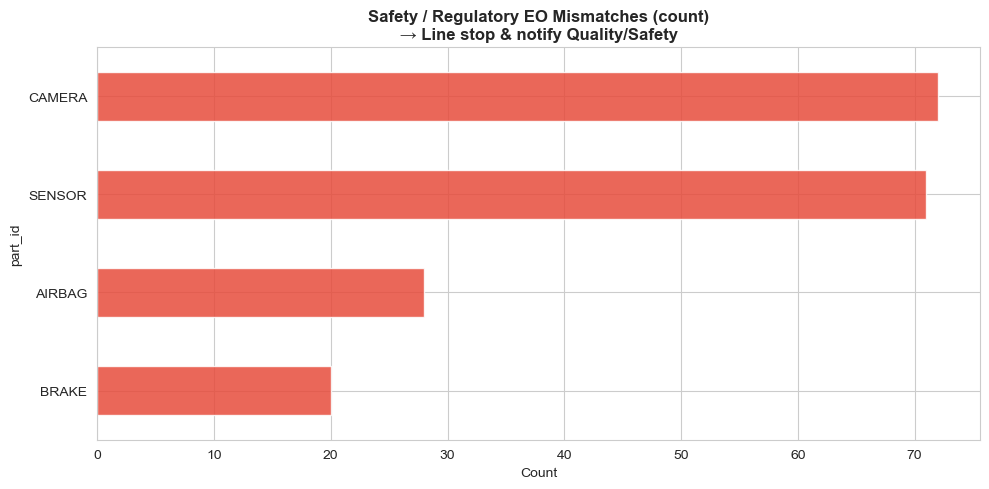

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

if len(safety_mismatch) > 0:
    by_part = safety_mismatch.groupby("part_id").size().sort_values(ascending=True)
    colors = [
        "#e74c3c" if p in ["AIRBAG", "BRAKE", "SENSOR", "CAMERA"] else "#3498db"
        for p in by_part.index
    ]
    by_part.plot(kind="barh", ax=ax, color=colors, alpha=0.85)
    ax.set_title(
        "Safety / Regulatory EO Mismatches (count)\n→ Line stop & notify Quality/Safety",
        fontsize=12, fontweight="bold",
    )
    ax.set_xlabel("Count")
else:
    ax.text(
        0.5, 0.5,
        "Safety / Regulatory EO\n0 mismatches\n(OK)",
        ha="center", va="center", fontsize=14, color="#27ae60"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

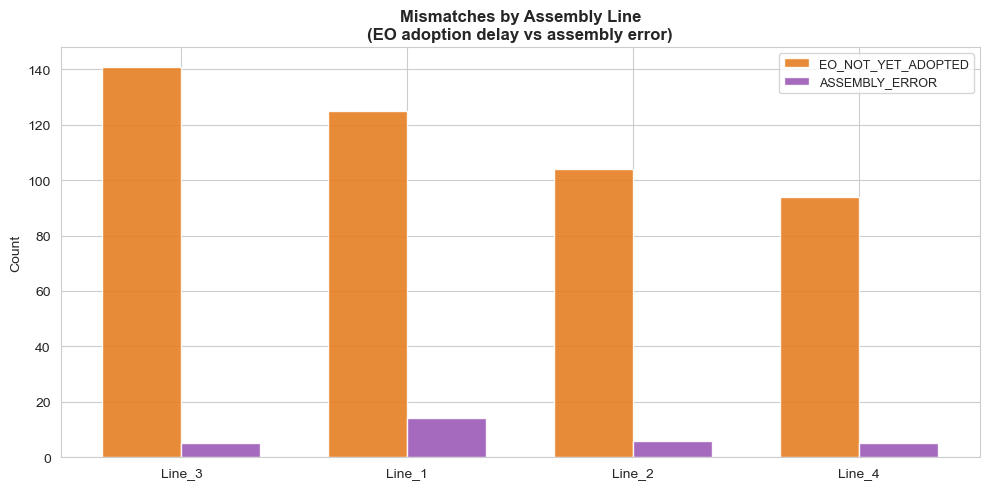

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))

if "by_line" in dir() and len(by_line) > 0:
    x = range(len(by_line))
    w = 0.35

    ax.bar(
        [i - w / 2 for i in x],
        by_line["eo_not_adopted"],
        w,
        label="EO_NOT_YET_ADOPTED",
        color="#e67e22",
        alpha=0.9,
    )
    ax.bar(
        [i + w / 2 for i in x],
        by_line["assembly_error"],
        w,
        label="ASSEMBLY_ERROR",
        color="#9b59b6",
        alpha=0.9,
    )
    ax.set_xticks(list(x))
    ax.set_xticklabels(by_line["assembly_line"])
    ax.set_ylabel("Count")
    ax.set_title(
        "Mismatches by Assembly Line\n(EO adoption delay vs assembly error)",
        fontsize=12, fontweight="bold",
    )
    ax.legend(loc="upper right", fontsize=9)
else:
    ax.text(
        0.5, 0.5,
        "No line-level data\n(Run section ③ first)",
        ha="center", va="center", fontsize=12
    )
    ax.axis("off")

plt.tight_layout()
plt.show()


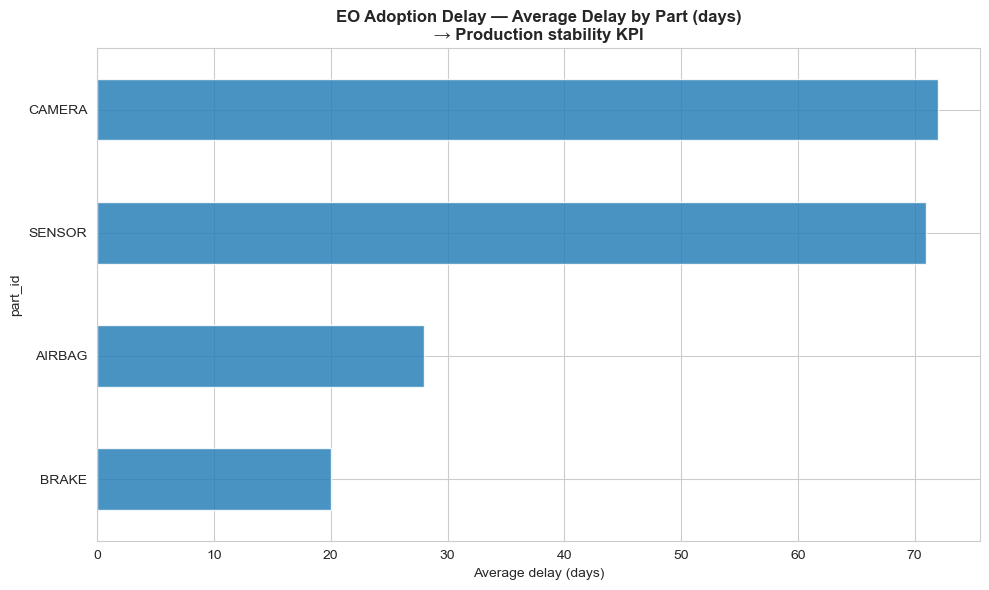

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

if "by_part" in dir() and len(by_part) > 0:
    by_part_sorted = by_part.sort_values(ascending=True)

    by_part_sorted.plot(
        kind="barh",
        ax=ax,
        color="#2980b9",
        alpha=0.85
    )
    ax.set_title(
        "EO Adoption Delay — Average Delay by Part (days)\n→ Production stability KPI",
        fontsize=12, fontweight="bold",
    )
    ax.set_xlabel("Average delay (days)")
else:
    ax.text(
        0.5, 0.5,
        "No delay data\n(Run section first)",
        ha="center", va="center", fontsize=12
    )
    ax.axis("off")

plt.tight_layout()
plt.show()


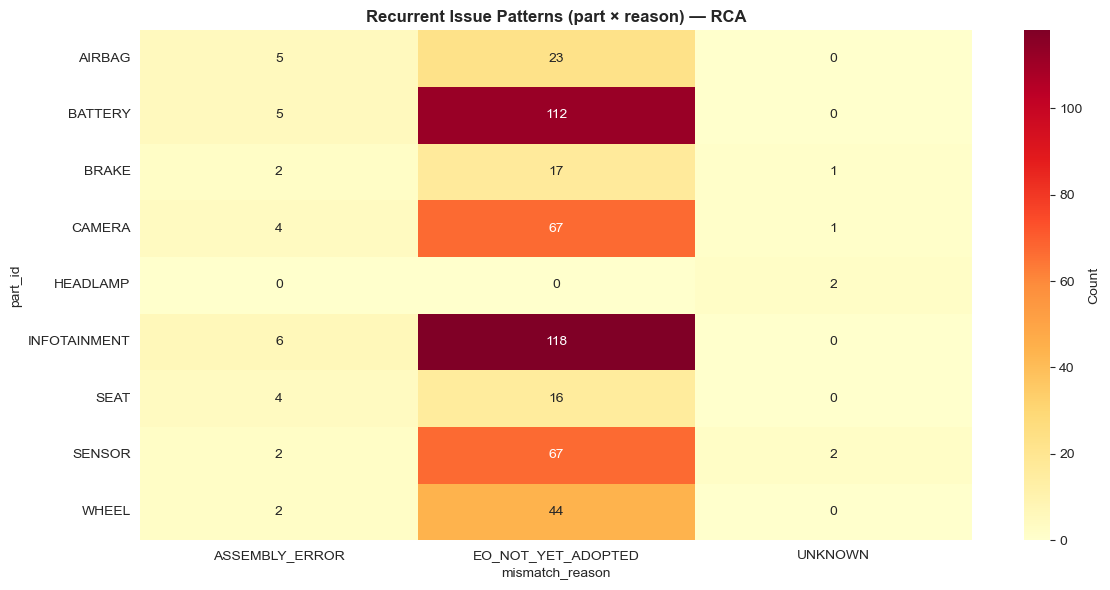

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

if "pattern" in dir() and len(pattern) > 0:
    pivot = pattern.pivot_table(
        index="part_id",
        columns="mismatch_reason",
        values="count",
        aggfunc="sum",
        fill_value=0,
    )

    if pivot.size > 0:
        sns.heatmap(
            pivot,
            annot=True,
            fmt=".0f",
            cmap="YlOrRd",
            ax=ax,
            cbar_kws={"label": "Count"},
        )
        ax.set_title(
            "Recurrent Issue Patterns (part × reason) — RCA",
            fontsize=12, fontweight="bold",
        )
    else:
        ax.text(0.5, 0.5, "Empty pivot table", ha="center", va="center")
        ax.axis("off")
else:
    ax.text(
        0.5, 0.5,
        "No pattern data\n(Run section first)",
        ha="center", va="center", fontsize=12
    )
    ax.axis("off")

plt.tight_layout()
plt.show()


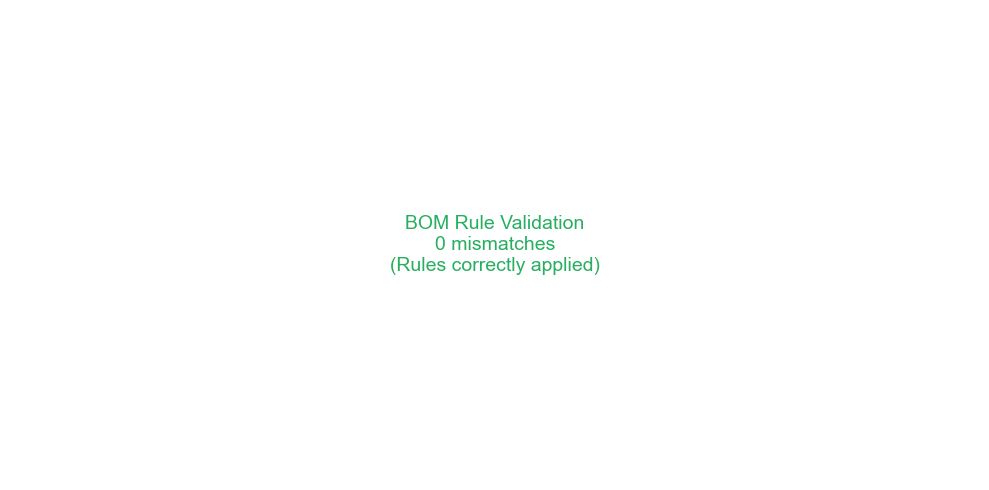

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

if len(bom_gap) > 0:
    gs = bom_gap.groupby("part_id").size().sort_values(ascending=True)
    gs.plot(kind="barh", ax=ax, color="#c0392b", alpha=0.85)
    ax.set_title(
        "BOM Rule Gaps (count by part)\n→ Check system / trim / model logic",
        fontsize=12, fontweight="bold",
    )
    ax.set_xlabel("Mismatch count")
else:
    ax.text(
        0.5, 0.5,
        "BOM Rule Validation\n0 mismatches\n(Rules correctly applied)",
        ha="center", va="center", fontsize=14, color="#27ae60"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()
